In [41]:
#########################
# Functions and Imports
#########################

#run this first

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.fft import fft, fftfreq
from scipy.special import jv
from PIL import Image
import cv2


def get_shape_H(mask,s,skin_depth,iterations,H0=1):
    k_squared = 2j / skin_depth**2  # complex number
    k = (1 + 1j) / skin_depth
    resolution = len(mask)
    x = np.linspace(0, s, resolution)  # x-axis points
    dx = x[1] - x[0]  # grid spacing in x

    # Define the initial condition
    z = np.ones((resolution, resolution), dtype=np.complex128)  # initial solution matrix
    for i in range(1, resolution - 1):  # loop over the interior points in x
        for j in range(1, resolution - 1):  # loop over the interior points in y
            if mask[i, j] == 1:
                r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*s
                z[i,j] = jv(0,r*k)/jv(0,s/2*k)


    # Time to iterate
    for n in range(iterations):
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 0:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) / (4 - k_squared * dx**2)
    return z

def get_skin_depth(rho,frequency=671111):
    return (2*rho/(4e-7*np.pi*2 * np.pi *frequency))**.5

def get_rgb_lists(image_path):
    with Image.open(image_path) as im:
        full_rgbs =  np.array(im)
    ylen = len(full_rgbs)
    xlen = len(full_rgbs[0])
    r = np.zeros([ylen,xlen])
    g = np.zeros([ylen,xlen])
    b = np.zeros([ylen,xlen])
    for y in range(ylen):
        for x in range(xlen):
            r[y][x] = full_rgbs[y][x][0]
            g[y][x] = full_rgbs[y][x][1]
            b[y][x] = full_rgbs[y][x][2]
    return r,g,b

def get_mask(image_path, cutoff1 = 150, cutoff2 = 150, kernal_size=55,):
    bs = get_rgb_lists(image_path)[2]
    intial_blur = cv2.blur(bs,(kernal_size,kernal_size)) #this takes the average of kernal_size by kernal_size region centered at each point
    made_cut = np.zeros([len(bs),len(bs[0])])
    first_cut = intial_blur.max()-intial_blur #this makes the dark spots highest amplitude
    for i in range(len(bs)):
        for j in range(len(bs[0])):
            if first_cut[i][j] < cutoff1:
                first_cut[i][j] = 0
            else:
                first_cut[i][j] -= cutoff1
                made_cut[i][j] = 255

    second_cut = cv2.blur(made_cut, (kernal_size, kernal_size))
    for i in range(len(bs)):
        for j in range(len(bs[0])):
            if second_cut[i][j] > cutoff2:
                second_cut[i][j] = 1
            else:
                second_cut[i][j] = 0
    second_cut_trans = np.transpose(second_cut)
    
    #find bounds of sample
    for i in range(len(bs)):
        if second_cut[i].sum()!=0:
            x1 = i
            break
    for j in range(len(bs)-1,-1,-1):
        if second_cut[j].sum()!=0:
            x2 = j
            break
    for i in range(len(bs[0])):
        if second_cut_trans[i].sum()!=0:
            y1 = i
            break
    for j in range(len(bs[0])-1,-1,-1):
        if second_cut_trans[j].sum()!=0:
            y2 = j
            break
    #return appriate square shape
    #this could break if the sample is too close to one of the edges and is a lot longer in one dimension, but thats fine. Avoid that. Good cropping
    diff = x2-x1-(y2-y1)
    if diff>0:#delta x is bigger than delta y
        if diff %2 == 0:
            return second_cut[x1-1:x2+2,y1-diff//2:y2+diff//2+1]
        else:
            return second_cut[x1-1:x2+2,y1-diff//2:y2+diff//2+2]
    else:#delta y is bigger than delta x
        if diff %2 == 0:
            return second_cut[x1+diff//2:x2-diff//2-1,y1-1:y2+2]
        else:
            return second_cut[x1+diff//2:x2-diff//2-2,y1-1:y2+2]

def get_dx(image_path):
    with Image.open(image_path) as im:
        full_rgbs =  np.array(im)
    ylen = len(full_rgbs)
    xlen = len(full_rgbs[0])
    r = np.zeros([ylen,xlen])
    g = np.zeros([ylen,xlen])
    b = np.zeros([ylen,xlen])
    for y in range(ylen):
        for x in range(xlen):
            r[y][x] = full_rgbs[y][x][0]
            g[y][x] = full_rgbs[y][x][1]
            b[y][x] = full_rgbs[y][x][2]

    boxes = .5e-3 # known mm /box

    # not_blue = (r+b)/2 #Now i am using cyan
    lefts = np.zeros(xlen)
    rights = np.zeros(xlen)
    tops = r[0]
    bottoms = r[ylen-1]
    for i in range(xlen):
        lefts[i] = r[i][0]
        rights[i] = r[i][xlen-1]

    top_amplitudes = fft(tops)
    bottom_amplitudes = fft(bottoms)
    left_amplitudes = fft(lefts)
    right_amplitudes = fft(rights)

    x_freqs = fftfreq(xlen, 1)[:xlen//2]# get the frequencies that coorespond to the amplitudes calculated in the previous line
    y_freqs = fftfreq(ylen, 1)[:xlen//2]# get the frequencies that coorespond to the amplitudes calculated in the previous line
    top_line_spacing = x_freqs[np.argmax(np.absolute(top_amplitudes)[1:xlen//2])+1]# this is the boxes per pixel
    bottom_line_spacing = x_freqs[np.argmax(np.absolute(bottom_amplitudes)[1:xlen//2])+1]
    left_line_spacing = y_freqs[np.argmax(np.absolute(left_amplitudes)[1:xlen//2])+1]
    right_line_spacing = y_freqs[np.argmax(np.absolute(right_amplitudes)[1:xlen//2])+1]

    dxs =[top_line_spacing,bottom_line_spacing,right_line_spacing,left_line_spacing] # this are the boxes per pixel

    return boxes * np.average(dxs) # the conversion makes dx in units of mm / pixel

def double_Integral(data, d):
    #https://stackoverflow.com/questions/20668689/integrating-2d-samples-on-a-rectangular-grid-using-scipy
    n = len(data)#assumes square 2d array that has physical length of d by d meters
    dA = ((d-0)/(n-1)) * ((d-0)/(n-1))

    data_Internal = data[1:-1, 1:-1]

    # sides: up, down, left, right
    (data_u, data_d, data_l, data_r) = (data[0, 1:-1], data[-1, 1:-1], data[1:-1, 0], data[1:-1, -1])

    # corners
    (data_ul, data_ur, data_dl, data_dr) = (data[0, 0], data[0, -1], data[-1, 0], data[-1, -1])

    return dA * (np.sum(data_Internal)\
                + 0.5 * (np.sum(data_u) + np.sum(data_d) + np.sum(data_l) + np.sum(data_r))\
                + 0.25 * (data_ul + data_ur + data_dl + data_dr))

44.95291328430176


Text(0.5, 1.0, 'Custom Shape Magnetic Field')

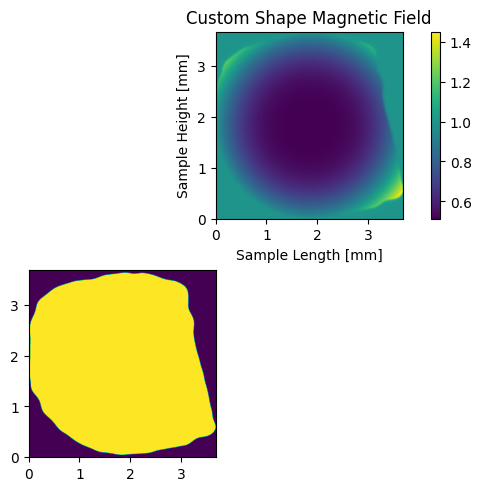

In [44]:
#Image Processing Parameters
image_path = "C:/Users/blake/Downloads/Sampletestpic.jpg"
#all the cutoffs have a range of 1 to 255. Good starting range is between 125 and 175 for both
cutoff1 = 125 #lower values will include more, but have more shadows
cutoff2 = 150 
kernal_size = 47 #must be odd, bigger will be less precise, but get rid of random noise, dots, etc
line_size = 15 #this must be an odd integer. It is the thickness of the edge lines

#FEA parameters
repeats = 100

mask = get_mask(image_path, cutoff1, cutoff2, kernal_size)

s = get_dx(image_path)*len(mask)

import time
t1 = time.time()
sample_H = get_shape_H(mask,s,get_skin_depth(2e-6),repeats)
t2 = time.time()
print(t2 - t1)

fig1 = plt.figure(constrained_layout = True)
ax = fig1.add_subplot(2, 1, 1)
bx = fig1.add_subplot(2, 1, 2)
p1 = ax.imshow(np.absolute(sample_H),extent=[0, s*1e3, 0, s*1e3])#,norm=colors.LogNorm(vmin=np.absolute(sample_H).min(), vmax=1))#,norm=colors.LogNorm(vmin=min(np.absolute(sample_H )), vmax=1))
fig1.colorbar(p1, ax=ax)
bx.imshow(np.absolute(mask),extent=[0, s*1e3, 0, s*1e3])
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title('Custom Shape Magnetic Field')

In [ ]:

##############################################
# Resistivity v Magnetic Susecptibility Phase
##############################################

rhos = np.logspace(-9,-4,100)
chis = np.zeros(len(rhos),dtype=np.complex_) #Stores the effective magnetic susceptibility for the sample

for i, rho in enumerate(rhos):
    sample_H = get_shape_H(mask,s,get_skin_depth(rho),repeats)
    chis[i] = double_Integral(sample_H,s)/s**2-1

fig2 = plt.figure(constrained_layout = True)
cx = fig2.add_subplot(1, 1, 1)
cx.plot(np.angle(chis),rhos*1e8)#-np.pi)
cx.set_ylabel(r'Resistivity [$\mu \Omega cm$]')
cx.set_xlabel(r'Phase of Magnetic Susceptibility$\chi$ [Rad]')
cx.set_yscale('log')
cx.set_title('Custom Shape Magnetic Field')